### Fault Example
#### Showcasing LoopStructural-Flopy to address Model Structure Uncertainty

This notebook showcases how with one parameter (fault_offset) multiple structural models can be generated for uncertainty in fault geometry using a 3D synthetic example. Corresponding flow models are automatically generated and run due to the seamless workflow. Results show significantly different head distributions for each structural model.

In [1]:
%run ./loop_showcase_functions.ipynb
#load from MODFLOW_tools (clone repo https://github.com/JimMcCallum/MODFLOW_Tools)
%run ../../MODFLOW_Tools/modelling_routines/modelling_routines.ipynb
%run ../../MODFLOW_Tools/meshing_routines/meshing_routines.ipynb
%run ../../MODFLOW_Tools/geomodel_routines/geomodel_routines.ipynb
%run ../../MODFLOW_Tools/loop2flopy/loop2flopy.ipynb
%run ../../MODFLOW_Tools/plotting_routines_USG/plotting_routines.ipynb

C:\Users\19904604\AppData\Local\Temp\ipykernel_19744\3209728366.py:21: DeprecationWarning: GeoPandas is set to use PyGEOS over Shapely. PyGEOS support is deprecatedand will be removed in GeoPandas 1.0, released in the Q1 of 2024. Please migrate to Shapely 2.0 (https://geopandas.org/en/stable/docs/user_guide/pygeos_to_shapely.html).
  import geopandas as gpd


Modelling routines loaded!
Meshing routines loaded!
Geomodel routines loaded!
loop2flopy routines loaded!
Plotting routines loaded!


In [13]:
P = Project('showcase', boundingbox = [0, 6000, 0, 6000, -500, 0]) # (x0, x1, y0, y1, z0, z1)

# Spatial information
P.crs = "epsg:28350" # Put in coordinate reference
P.xypumpbores = [] 
P.npump = len(P.xypumpbores)
P.idpumpbores = ['P1', 'P2'] 
P.xyobsbores = [(1500,1000), (2500, 5000), (4000, 3000), (5000,1500)]
P.idobsbores = ['OB1', 'OB2', 'OB3', 'OB4'] 
P.geo_coords=[(500,500), (1600, 2800), (5500,5500), (2800,1600)]
P.geo_bores = ['P1', 'P2', 'P3', 'P4']

# Observation Points
P.nobs = len(P.xyobsbores)
obs_z = [-40, -50, -100, -200, -300]
P.nzobs = len(obs_z)
P.zobs = np.ones((P.nobs, P.nzobs))
for j in range(P.nzobs):
    P.zobs[:, j] = P.zobs[:, j] * obs_z[j] 

# Meshing parameters
P.triExeName = '../exe/triangle.exe'
P.fx1, P.fy1, P.fx2, P.fy2 = (2000, 4500, 3000, 1000) # fault end points
P.fault_buffer = 150.  # offset boundary from fault
P.r = 40               # refining factor for model boundary. High r has refined edges
P.w = 150              # interior boundary offset
P.boundmaxtri = 50000  # max triangle area in boundary area
P.modelmaxtri = 50000  # max triangle area in main model area
P.angle = 32           # minimum triangle angles
P.radius1 = 100        # radius of inner circle around pumping bores
P.radius2 = 200        # radius of outer circle around pumping bores
P.boremaxtri = 100000   # max triangle area within bore radius

# Flow model parameters
P.mfexe_name = '../exe/mf6.exe'
P.workspace = '../modelfiles/'
P.nlg = 4    # number of geological layers
P.nls = 3    # number sublayers for conformable
P.nlv  = 30  # number of layers for voxel transect grid

P.hk = [1, 2, 0.01, 5] 
P.vk = [i/10 for i in P.hk]
P.ss = [0.0001, 0.00001, 0.0001, 0.0001]
P.sy = [0.1, 0.1, 0.1, 0.1]
P.rch = 0.4/365 # 0.0027 m/d
P.strt = -20.
P.chfunc = lambda x,z: -(0.005*x) - (z * 0.02)-20 # horizontal gradient of 0.01 and vertical gradient of 0.02
P.xt3d = True
   
vtk_workspace = '../vtk_files'
if not os.path.isdir(vtk_workspace):
    os.makedirs(vtk_workspace, exist_ok=True)

In [14]:
P.cell2dtri, P.xcyctri, P.verticestri, P.tri, trinodes = createcell2d(P, grid = 'tri', fault = True)  
P.cell2dvor, P.xcycvor, P.verticesvor, P.vor, vornodes = createcell2d(P, grid = 'vor', fault = True)  

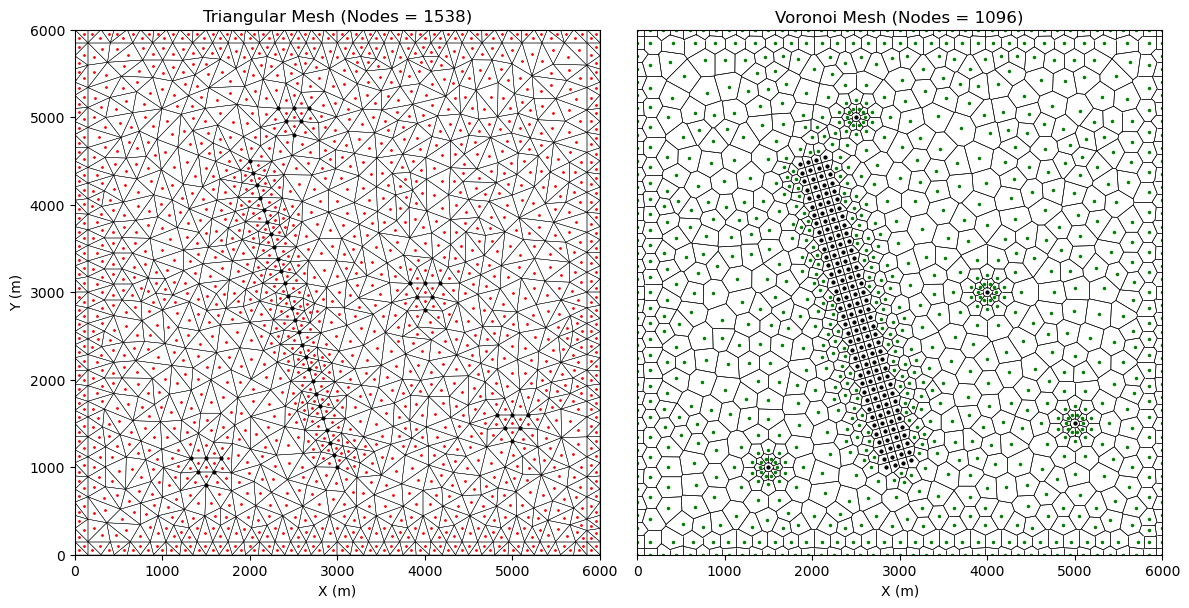

In [15]:
def figure2(P):
    
    fig = plt.figure(figsize=(12,7))
    ax = plt.subplot(1, 2, 1, aspect='equal')
    P.tri.plot(edgecolor='black', lw = 0.3)
    P.tri.plot_centroids(ax=ax, marker='o', markersize = '1.', color='red')   
    for i in trinodes: ax.plot(i[0], i[1], 'o', ms = 2, color = 'black')
    for i in range(P.npump): ax.plot(P.xypumpbores[i], ms = 5, color = 'blue', zorder=2.)
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_title('Triangular Mesh (Nodes = %i)' %len(P.cell2dtri))
    
    ax = plt.subplot(1, 2, 2, aspect='equal')
    P.vor.plot(ax=ax, edgecolor='black', lw = 0.4)
    for i in P.xcycvor: ax.plot(i[0], i[1], 'o', color = 'green', ms = 1.5)
    for i in vornodes: ax.plot(i[0], i[1], 'o', ms = 2, color = 'black')
    for i in range(P.npump): ax.plot(P.xypumpbores[i], ms = 2, color = 'blue', zorder=2.)
    ax.set_xlabel('X (m)')
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.set_title('Voronoi Mesh (Nodes = %i)' %len(P.cell2dvor))
    
    plt.subplots_adjust(wspace=0.05, hspace=0.1)    
    plt.tight_layout()  
    plt.show()   
    fig.savefig('../figures/fig2.tif', dpi=300)
    
figure2(P)

In [16]:
 #plot_cell2d_vor(P, xlim = [P.x0, P.x1], ylim = [P.y0, P.y1]) #xlim = [0, 3500], ylim = [0, 3500]

In [ ]:
# Create a vtk object
vtkobj = vtk.Vtk(ml, vertical_exageration=10)
vtkobj.add_array(array, "array_name")
vtkobj.add_array(ml.dis.botm.array, "botm")

f = os.path.join(vtk_workspace, "faults","name.vtu")
vtkobj.write(f)

### Faults - multiple simulations

In [17]:
options = np.linspace(0, 320, 6) # Fault displacement


data = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "fault_example")
strat = pd.read_excel("../data/loop_showcase_data.xls",sheet_name = "strat")

P.control_points = ([])
P.fault_max_disp = 100.    # Was 200
P.minor_axis = 1000        # Fault_influence - orthogonal to fault
P.fault_center = [P.fx1 + (P.fx2 - P.fx1)/2, P.fy1 + (P.fy2 - P.fy1)/2, -400]
P.fault_slip_vector=[0,0,1]
    
fault_modelnames, fault_models, fault_obs_heads = [],[],[]         

for i in range(len(options)):
    fault_modelnames.append(str('FD_'+str(options[i])))  
    fault_models.append(Model(fault_modelnames[i], P, plan = 'vor', transect = 'con')) # Create flow model  
    P.fault_max_disp = options[i] /2
    P.data, P.strat = prepare_geomodel_loopshowcase(P, data, strat, include_fault = True)   # Prepare geomodel inputs
    P.geomodel = create_geomodel_loopshowcase(P, include_fault = True) # Make geomodel
    M = fault_models[i]
    M.create_lith_dis_arrays(P)                                 # Create lith and dis arrays
    M.create_prop_arrays(P)                                     # Create K arrays
    M.create_flow_package_arrays(P)                             # Create flow packages
    M.gwf, M.head_ss, M.obs_ss, M.runtime_ss = M.write_run_model(P, period = 'Steady', ic_array = P.strt)   
    fault_obs_heads.append((process_obs_steady(P, M)))
    f = os.path.join(vtk_workspace, "faults", M.modelname)
    M.gwf.export(f, fmt="vtk")

                          projected onto fault surface estimating from fault normal
C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
Creating lithology and discretisation arrays for  FD_0.0  ...
Time taken =  2.402265
Creating property arrays for  FD_0.0  ...
Time taken =  0.008055
Adding flow packages to  FD_0.0  ...
Time taken =  0.743808
Writing simulation and gwf for  FD_0.0  ...
FD_0.0
Running simulation for  FD_0.0  ...
Period =  Steady 
Model success =  True
run_time =  26.440191


                          projected onto fault surface estimating from fault normal
C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
Creating lithology and discretisation arrays for  FD_64.0  ...
Time taken =  20.410476
Creating property arrays for  FD_64.0  ...
Time taken =  0.01015
Adding flow packages to  FD_64.0  ...
Time taken =  0.731419
Writing simulation and gwf for  FD_64.0  ...
FD_64.0
Running simulation for  FD_64.0  ...
Period =  Steady 
Model success =  True
run_time =  19.862158


                          projected onto fault surface estimating from fault normal
C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
Creating lithology and discretisation arrays for  FD_128.0  ...
Time taken =  20.969734
Creating property arrays for  FD_128.0  ...
Time taken =  0.010104
Adding flow packages to  FD_128.0  ...
Time taken =  0.765319
Writing simulation and gwf for  FD_128.0  ...
FD_128.0
Running simulation for  FD_128.0  ...
Period =  Steady 
Model success =  True
run_time =  23.895778


                          projected onto fault surface estimating from fault normal
C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
Creating lithology and discretisation arrays for  FD_192.0  ...
Time taken =  20.464
Creating property arrays for  FD_192.0  ...
Time taken =  0.010128
Adding flow packages to  FD_192.0  ...
Time taken =  0.7555
Writing simulation and gwf for  FD_192.0  ...
FD_192.0
Running simulation for  FD_192.0  ...
Period =  Steady 
Model success =  True
run_time =  26.344786


                          projected onto fault surface estimating from fault normal
C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
Creating lithology and discretisation arrays for  FD_256.0  ...
Time taken =  20.071986
Creating property arrays for  FD_256.0  ...
Time taken =  0.010196
Adding flow packages to  FD_256.0  ...
Time taken =  0.876324
Writing simulation and gwf for  FD_256.0  ...
FD_256.0
Running simulation for  FD_256.0  ...
Period =  Steady 
Model success =  True
run_time =  29.938683


                          projected onto fault surface estimating from fault normal
C:\Users\19904604\Anaconda3\envs\loop3denvu\lib\site-packages\LoopStructural\modelling\core\geological_model.py:647: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap(cmap, n_units)


Fault included!
{'upper': 0, 'upper_unconformity': 1, 'Fault': 2, 'lower': 3}
Creating lithology and discretisation arrays for  FD_320.0  ...
Time taken =  21.012575
Creating property arrays for  FD_320.0  ...
Time taken =  0.010332
Adding flow packages to  FD_320.0  ...
Time taken =  0.782828
Writing simulation and gwf for  FD_320.0  ...
FD_320.0
Running simulation for  FD_320.0  ...
Period =  Steady 
Model success =  True
run_time =  30.057397


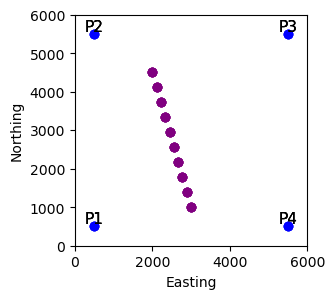

In [18]:
plot_bores(P)

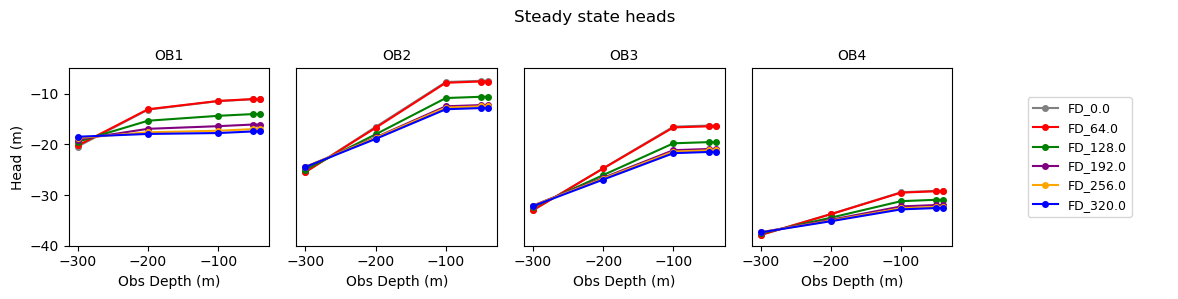

C:\Users\19904604\AppData\Local\Temp\ipykernel_19744\449695775.py:13: UserWarning: Warning: converting a masked element to nan.
  if math.isnan(h) == False:


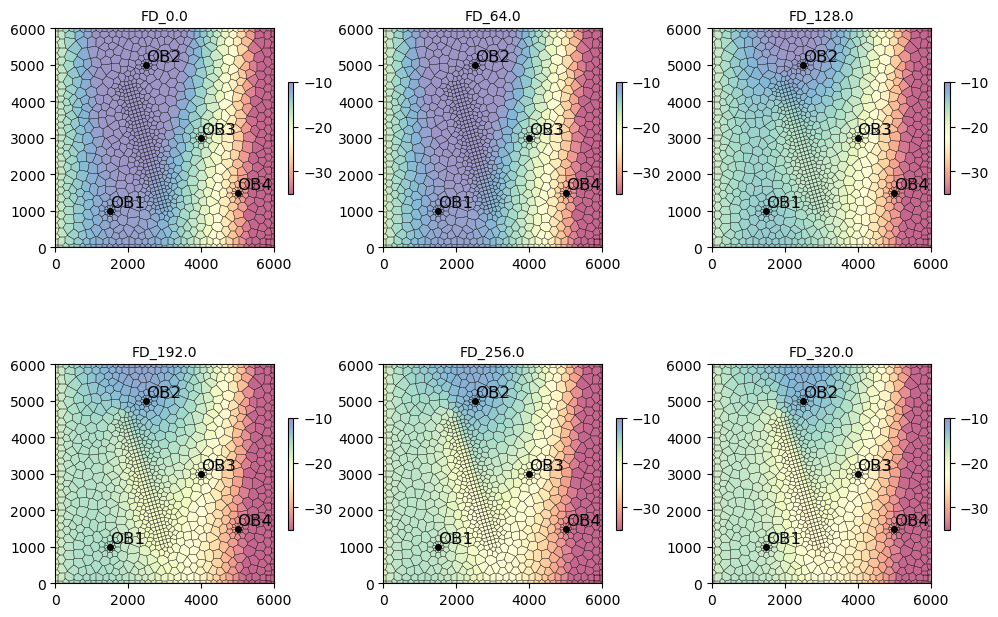

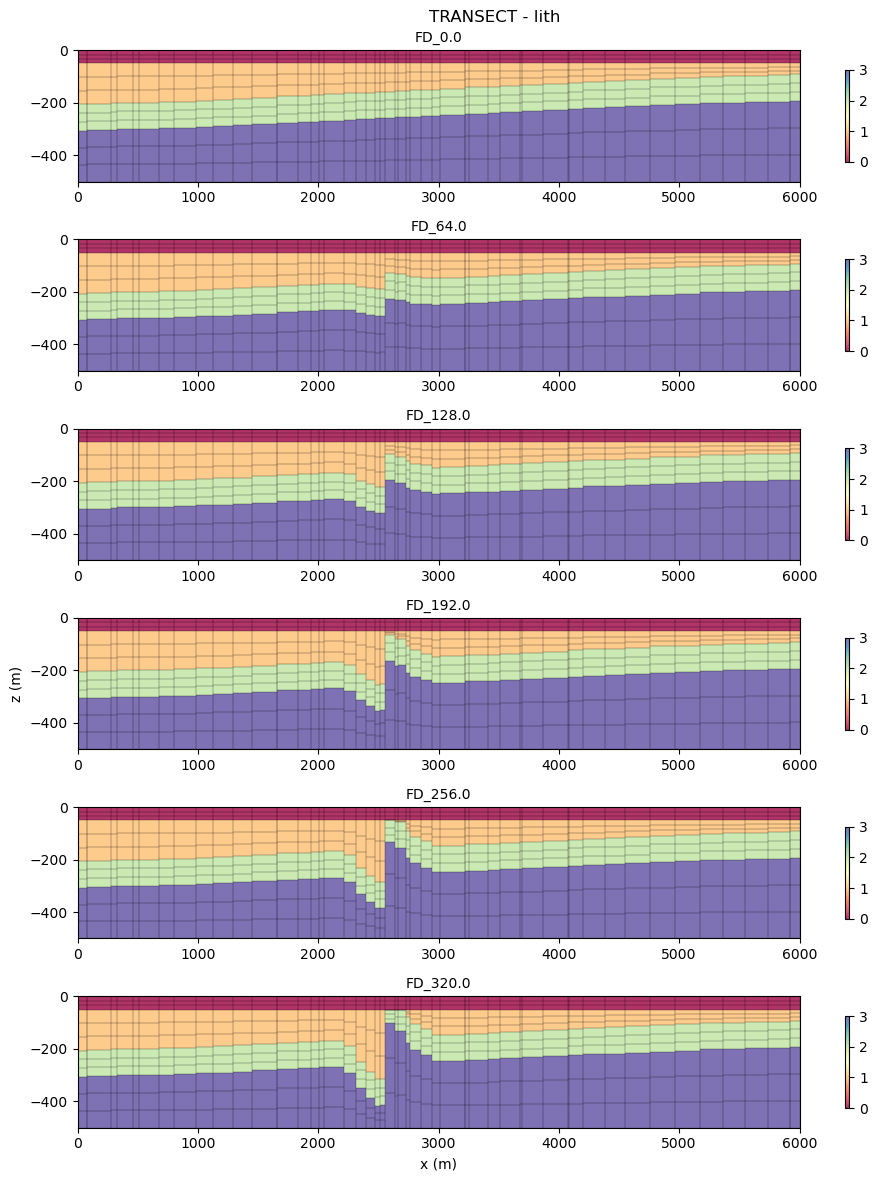

In [19]:
# PLOTS
plot_observations(heads = fault_obs_heads, modelnames = fault_modelnames, ylim = [-40, -5])
plot_bylayer(P, models = fault_models, layer = 2, vmin = -35, vmax = -10) 
multiplot_vgrid_transect(P, models = fault_models, array = 'lith', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1)

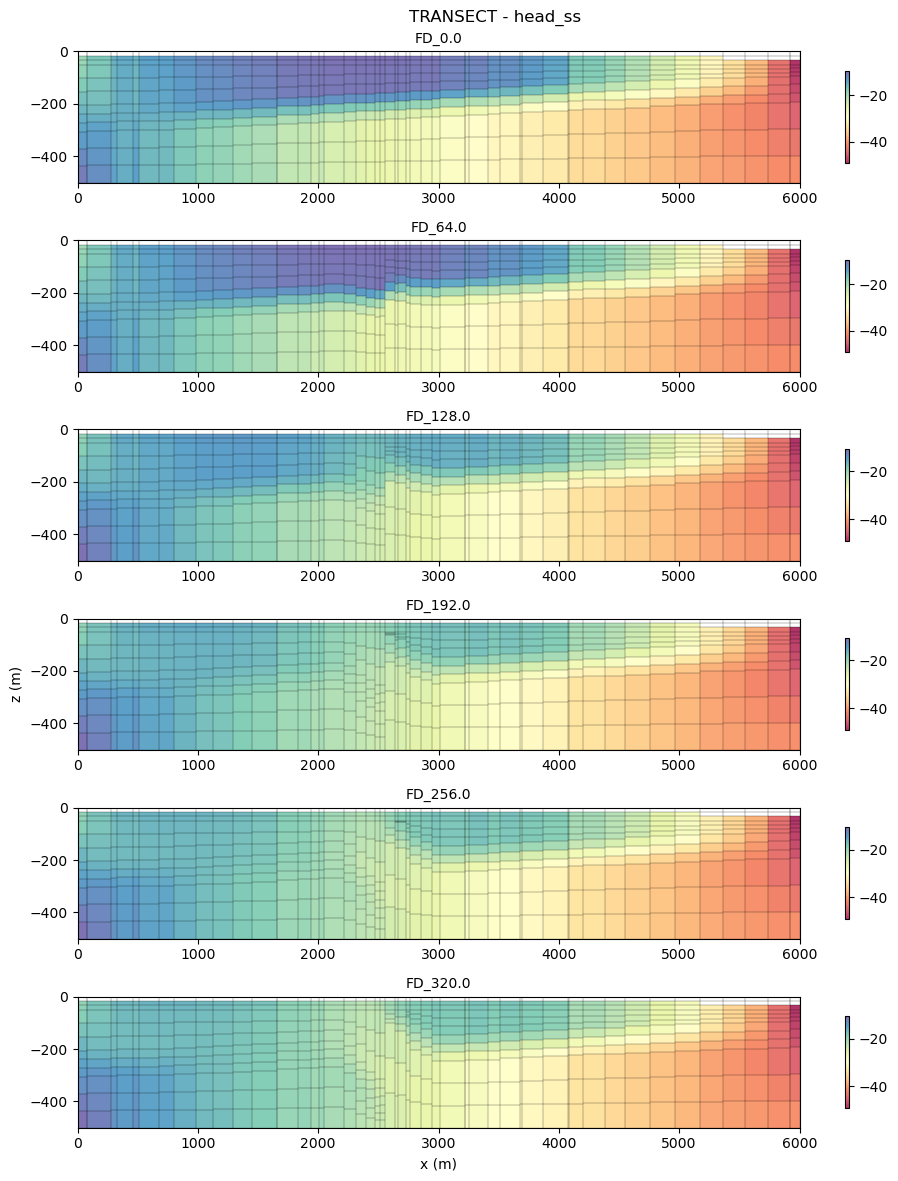

In [20]:
multiplot_prop_transect(P, models = fault_models, array = 'head_ss', X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1,)

C:\Users\19904604\AppData\Local\Temp\ipykernel_19744\398711091.py:6: UserWarning: Warning: converting a masked element to nan.
  if math.isnan(h) == False:


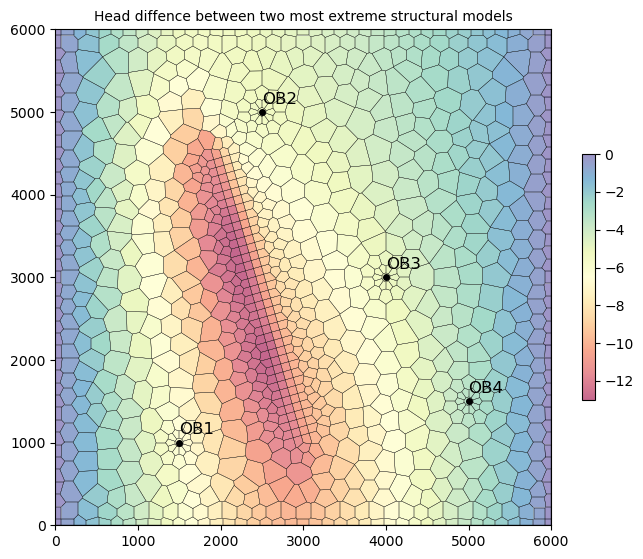

In [21]:
heads_A = find_watertable_disu(P, M = fault_models[-1], layer = 2)
heads_B = find_watertable_disu(P, M = fault_models[0], layer = 2)
plot_head_diff(P, fault_models[0], heads_A, heads_B, vmin = 0, vmax = 50) 

In [22]:
from matplotlib.lines import Line2D
colors = {'1':'tab:orange', '2':'tab:red', '0.01':'tab:purple', '5':'tab:brown'}
handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]
col = []
for k in P.hk:
    col.append(str(k))

C:\Users\19904604\AppData\Local\Temp\ipykernel_19744\2428754488.py:73: UserWarning: Warning: converting a masked element to nan.
  if math.isnan(h) == False:
C:\Users\19904604\AppData\Local\Temp\ipykernel_19744\2428754488.py:73: UserWarning: Warning: converting a masked element to nan.
  if math.isnan(h) == False:
C:\Users\19904604\AppData\Local\Temp\ipykernel_19744\2428754488.py:73: UserWarning: Warning: converting a masked element to nan.
  if math.isnan(h) == False:
C:\Users\19904604\AppData\Local\Temp\ipykernel_19744\2428754488.py:105: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
C:\Users\19904604\AppData\Local\Temp\ipykernel_19744\2428754488.py:105: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


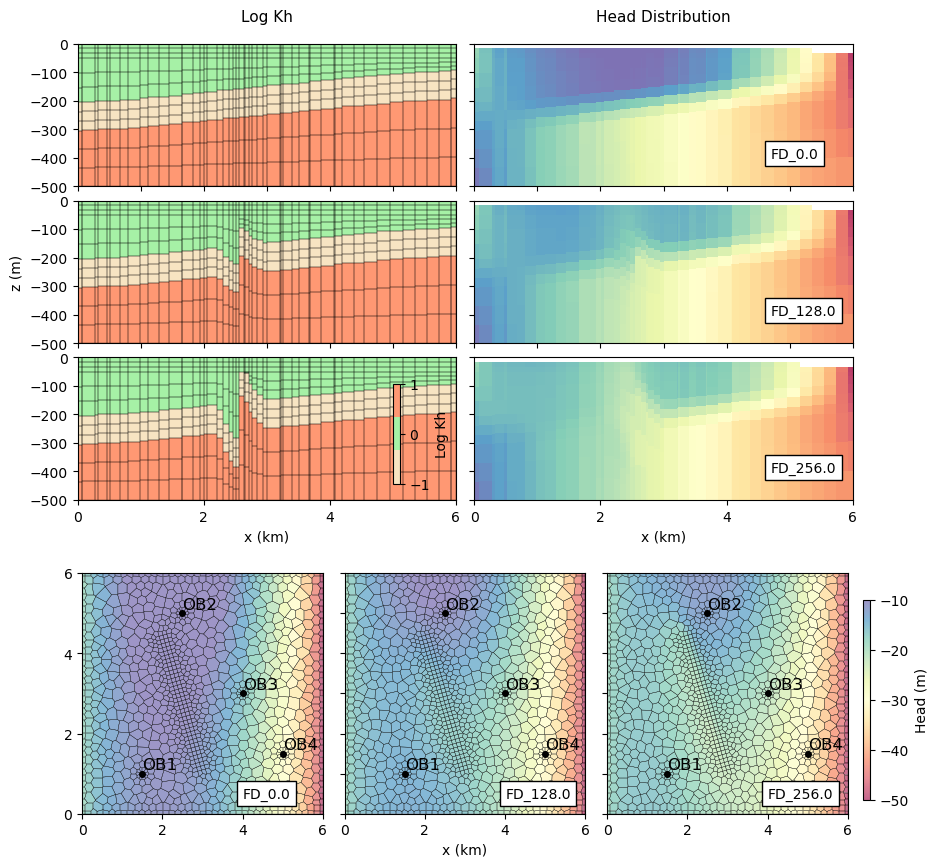

In [23]:
#%run ./figures_paper.ipynb
def figure4(P, models, X0, Y0, X1, Y1, vmin = None, vmax = None): # array needs to be a string of a property eg. 'k11', 'angle2'
    
    c = mpl.colors.ListedColormap(['wheat', 'lightgreen', 'coral'])
    n = mpl.colors.Normalize(vmin=-1,vmax=1)
    
    fig = plt.figure(figsize = (10,10))
    #fig.suptitle("TRANSECT - " + array)
    nm = [0,2,4]
    for i in nm:
        ax = plt.subplot(5, 2, i+1)
        M = models[i]
        model = M.gwf
        a = getattr(M, 'k11')
        xsect = flopy.plot.PlotCrossSection(model=model, line={"line": [(X0, Y0),(X1, Y1)]}, 
                                            extent = [P.x0,P.x1,P.z0,P.z1], geographic_coords=True)
        
            
        csa = xsect.plot_array(a = logfunc(a), cmap=c, norm=n, alpha=0.8, vmin = vmin, vmax = vmax) #cmap=c, norm=n, 
        ax.set_ylim([-500, 0])
        
        linecollection = xsect.plot_grid(lw = 0.2, color = 'black') # Don't plot grid for reference
        #plt.colorbar(csa, shrink = 0.7)
        cb_ax = fig.add_axes([.44,.44,.007,0.1])
        fig.colorbar(csa,orientation='vertical',cax=cb_ax, label='Log Kh')
        
        if i == 0:
            ax.set_title('Log Kh', y=1.1, size = 11)
            #ax.plot(P1_L, -50, color='black', marker='o', markerfacecolor='lightblue', markersize=8)
            #ax.annotate("P1",(P1_L, 20), size = 10, ha = 'center', annotation_clip = False)
        if i == 0:
            ax.set(xticklabels=[])
        if i == 2:
            ax.set_ylabel('z (m)', size = 10)
            ax.set(xticklabels=[])
        if i == 4: 
            ax.set_xlabel('x (km)', size = 10)
            ax.set_xticks([0, 2000, 4000, 6000])
            ax.set_xticklabels([0, 2, 4, 6])
        
    for i in nm:
        ax = plt.subplot(5, 2, i+2)
        M = models[i]
        model = M.gwf
        a = getattr(M, 'head_ss')
        xsect = flopy.plot.PlotCrossSection(model=model, line={"line": [(X0, Y0),(X1, Y1)]}, 
                                            extent = [P.x0,P.x1,P.z0,P.z1], geographic_coords=True)
        csa = xsect.plot_array(a = a, cmap='Spectral', alpha=0.8, vmin = -40, vmax = -5)
        ax.set_ylim([-500, 0])
        ax.annotate(M.modelname, (4700, -400), size = 10, bbox=dict(facecolor = 'white'))
        if i == 0:
            ax.set(xticklabels=[])
            ax.set(yticklabels=[])
            ax.set_title('Head Distribution', y = 1.1, size = 11)
        if i == 2:
            ax.set(xticklabels=[])
            ax.set(yticklabels=[])
        if i == 4: 
            ax.set_xlabel('x (km)', size = 10)
            ax.set_xticks([0, 2000, 4000, 6000])
            ax.set_xticklabels([0, 2, 4, 6])
            ax.set(yticklabels=[])
        #plt.colorbar(csa, shrink = 0.7)
        
    for i in nm:
        layer = 2
        ax = plt.subplot(3, 3, int(i/2 + 7))
        M = models[i]
        model = M.gwf
        water_table = flopy.utils.postprocessing.get_water_table(M.gwf.output.head().get_data())
        M.heads_disv = -1e30 * np.ones_like(M.idomain, dtype=float) 
        for k, h in enumerate(water_table):
            if math.isnan(h) == False: 
                M.heads_disv[M.cellid_disu==k] = h        
        pmv = flopy.plot.PlotMapView(modelgrid=M.vgrid)
        H = pmv.plot_array(M.heads_disv[layer], cmap = 'Spectral', alpha = 0.6, vmin = -40, vmax = -5) #
        for j in range(len(P.xyobsbores)):
            ax.plot(P.xyobsbores[j][0], P.xyobsbores[j][1],'o', ms = '4', c = 'black')
            ax.annotate(P.idobsbores[j], (P.xyobsbores[j][0], P.xyobsbores[j][1]+100), c='black', size = 12) #, weight = 'bold')
        
        for j in range(len(P.xypumpbores)):
            ax.plot(P.xypumpbores[j][0], P.xypumpbores[j][1],'o', ms = '4', c = 'red')
            ax.annotate(P.idpumpbores[j], (P.xypumpbores[j][0], P.xypumpbores[j][1]+100), c='red', size = 12) #, weight = 'bold')
            
        if M.plan == 'car': P.sg.plot(ax=ax, edgecolor='black', lw = 0.2)
        if M.plan == 'tri': P.tri.plot(ax=ax, edgecolor='black', lw = 0.2)
        if M.plan == 'vor': P.vor.plot(ax=ax, edgecolor='black', lw = 0.2)
        if i == 2: ax.set_yticklabels([])
        if i == 2: ax.set_xlabel('x (km)', size = 10)
        if i == 4: ax.set(yticklabels=[])
        if i == 0:
            ax.set_yticks([0, 2000, 4000, 6000])
            ax.set_yticklabels([0, 2, 4, 6])
        
        ax.set_title(' ') 
        ax.set_xticks([0, 2000, 4000, 6000])
        ax.set_xticklabels([0, 2, 4, 6])
        #plt.colorbar(H, shrink = 0.7)
        ax.annotate(M.modelname, (4000, 400), size = 10, bbox=dict(facecolor = 'white'))
    cb_ax = fig.add_axes([.91,.124,.007,0.2])
    fig.colorbar(H,orientation='vertical',cax=cb_ax, label = 'Head (m)')


    plt.subplots_adjust(wspace=0.05, hspace=0.1)    
    plt.tight_layout()  
    plt.show()   
    fig.savefig('../figures/fig4.tif', dpi=300)

figure4(P, models = fault_models, X0 = P.x0, Y0 = P.y0, X1 = P.x1, Y1 = P.y1,)